In [ ]:
import numpy as np
import geopandas as gpd

from explore import *
from graphic import *
from utils import *

df = read_burn_df()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bar_limited(
    df["simp_satelite"].value_counts(),
    ax=axs[0],
    title='Dados gerados por cada satélite desde 1998',
    xlabel='Satélite',
    ylabel='Detecções'
)

bar_limited(
    df[(df['datahora'].dt.year == 2022)]["simp_satelite"].value_counts(),
    ax=axs[1],
    title='Dados gerados por cada satélite em 2022',
    xlabel='Satélite',
    ylabel='Detecções'
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bar_limited(
    df["sensor"].value_counts(),
    ax=axs[0],
    title='Dados gerados por cada sensor desde 1998',
    xlabel='Sensor',
    ylabel='Detecções'
)

bar_limited(
    df[(df['datahora'].dt.year == 2022)]["sensor"].value_counts(),
    ax=axs[1],
    title='Dados gerados por cada sensor em 2022',
    xlabel='Sensor',
    ylabel='Detecções'
)

In [50]:
# Pastas dos shapes
aux_folder = os.path.join(directory, "aux")
uf_folder = os.path.join(aux_folder, "ibge/BR_UF_2021")
municipios_folder = os.path.join(aux_folder, "ibge/BR_Municipios_2021")
biomas_folder = os.path.join(aux_folder, "ibge/Biomas_250mil")

estados_shape: gpd.GeoDataFrame = gpd.read_file(uf_folder + '/BR_UF_2021.shp')
municipios_shape: gpd.GeoDataFrame = gpd.read_file(municipios_folder + '/BR_Municipios_2021.shp')
biomas_shape: gpd.GeoDataFrame = gpd.read_file(biomas_folder + '/lm_bioma_250.shp')

# processamento para ser compatível com os dados do INPE
estados_shape['NM_UF'] = estados_shape['NM_UF'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
municipios_shape['NM_MUN'] = municipios_shape['NM_MUN'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
biomas_shape['Bioma'] = biomas_shape['Bioma'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()

# falta as áreas dos estados no dado do ibge, bora garimpar elas
estados_shape = pd.merge(
    left=estados_shape,
    right=municipios_shape.groupby(['SIGLA'])['AREA_KM2'].sum(),
    left_on=['SIGLA'],
    right_on=['SIGLA']
)

# dados do ibge também https://brasilemsintese.ibge.gov.br/territorio.html
biomas_shape['AREA_KM2'] = biomas_shape['Bioma'].map({
    'AMAZONIA': 4196943,
    "CERRADO": 2036448,
    "MATA ATLANTICA": 1110182,
    "CAATINGA": 844453,
    "PAMPA": 176496,
    "PANTANAL": 150355
})


In [51]:
# improve performance of graphic render in pdf
estados_shape.geometry = estados_shape.simplify(0.01)
municipios_shape.geometry = municipios_shape.simplify(0.01)
biomas_shape.geometry = biomas_shape.simplify(0.01)


In [52]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
municipios_counts = reference_df.groupby(['municipio'])['municipio'].count().rename('count').to_frame()
municipios_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=municipios_counts,
        right=municipios_shape,
        left_on=['municipio'],
        right_on=['NM_MUN'],
        how='inner'
    )
)
municipios_counts_with_shape['count_by_km2'] = municipios_counts_with_shape['count'] / municipios_counts_with_shape['AREA_KM2']

estados_counts = reference_df.groupby(['estado'])['estado'].count().rename('count').to_frame()
estado_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=estados_counts,
        right=estados_shape,
        left_on=['estado'],
        right_on=['NM_UF'],
        how='inner'
    )
)
estado_counts_with_shape['count_by_km2'] = estado_counts_with_shape['count'] / estado_counts_with_shape['AREA_KM2']

bioma_counts = reference_df.groupby(['bioma'])['bioma'].count().rename('count').to_frame()
bioma_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=bioma_counts,
        right=biomas_shape,
        left_on=['bioma'],
        right_on=['Bioma'],
        how='inner'
    )
)
bioma_counts_with_shape['count_by_km2'] = bioma_counts_with_shape['count'] / bioma_counts_with_shape['AREA_KM2']

regiao_counts_with_shape = estado_counts_with_shape.dissolve(by='NM_REGIAO').reset_index()[['NM_REGIAO', 'geometry']]
regiao_counts_with_shape['AREA_KM2'] = estados_shape.groupby('NM_REGIAO')['AREA_KM2'].sum().values
regiao_counts_with_shape['count'] = estado_counts_with_shape.groupby('NM_REGIAO')['count'].sum().values
regiao_counts_with_shape['count_by_km2'] = regiao_counts_with_shape['count'] / regiao_counts_with_shape['AREA_KM2']


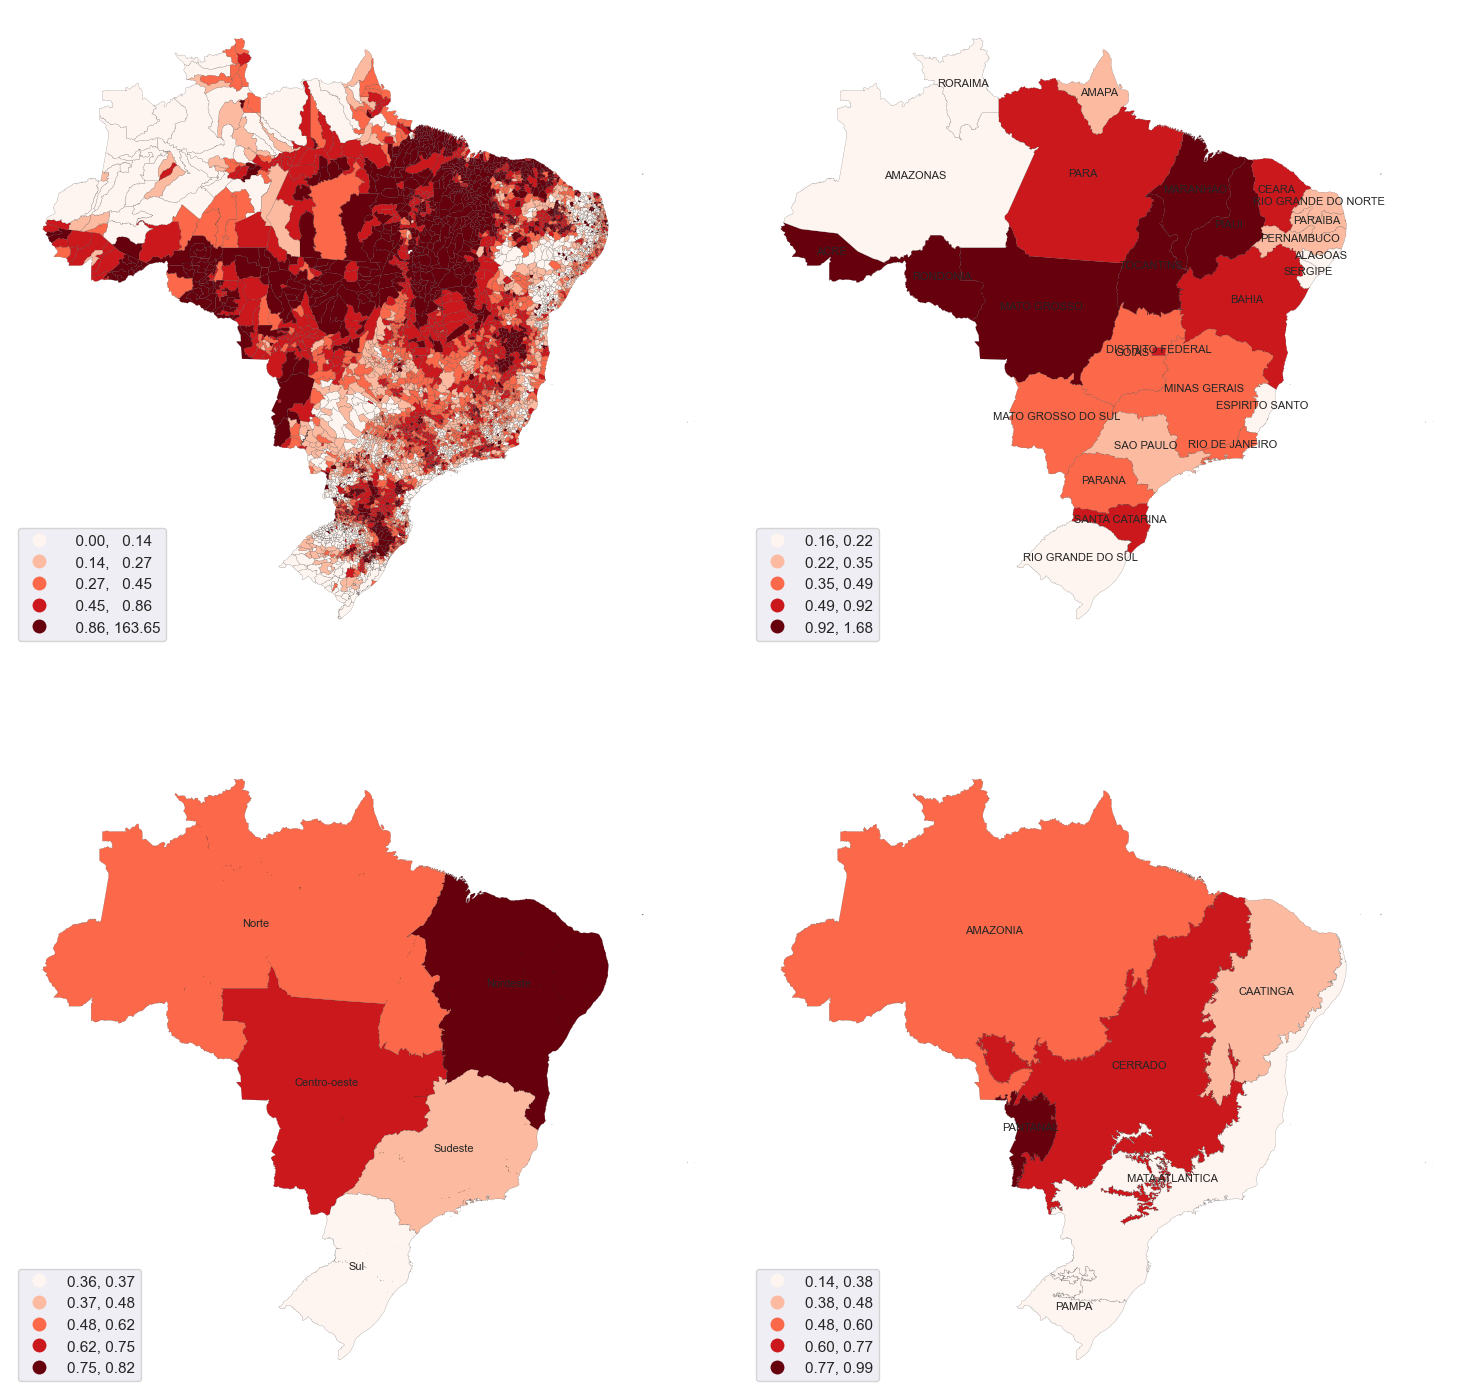

In [87]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
fig.tight_layout(pad=0)
fontsize=8

municipios_counts_with_shape.plot(
    ax=ax1,
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
# municipios_counts_with_shape.apply(
#     lambda x: ax1.annotate(text=x['NM_MUN'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=fontsize/3), 
#     axis=1
# )

estado_counts_with_shape.plot(
    ax=ax2,
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
estado_counts_with_shape.apply(
    lambda x: ax2.annotate(text=x['NM_UF'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=fontsize), 
    axis=1
)

regiao_counts_with_shape.plot(
    ax=ax3,
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
regiao_counts_with_shape.apply(
    lambda x: ax3.annotate(text=x['NM_REGIAO'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=fontsize), 
    axis=1
)

bioma_counts_with_shape.plot(
    ax=ax4,
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
bioma_counts_with_shape.apply(
    lambda x: ax4.annotate(text=x['Bioma'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=fontsize), 
    axis=1
)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

fig.savefig(os.path.join(image_folder, 'brasil_focos.pdf'), bbox_inches="tight")

/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/ipykernel_14439/3489174013.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: EPSG:4326

  join = gpd.sjoin(estados_shape, wrs2)


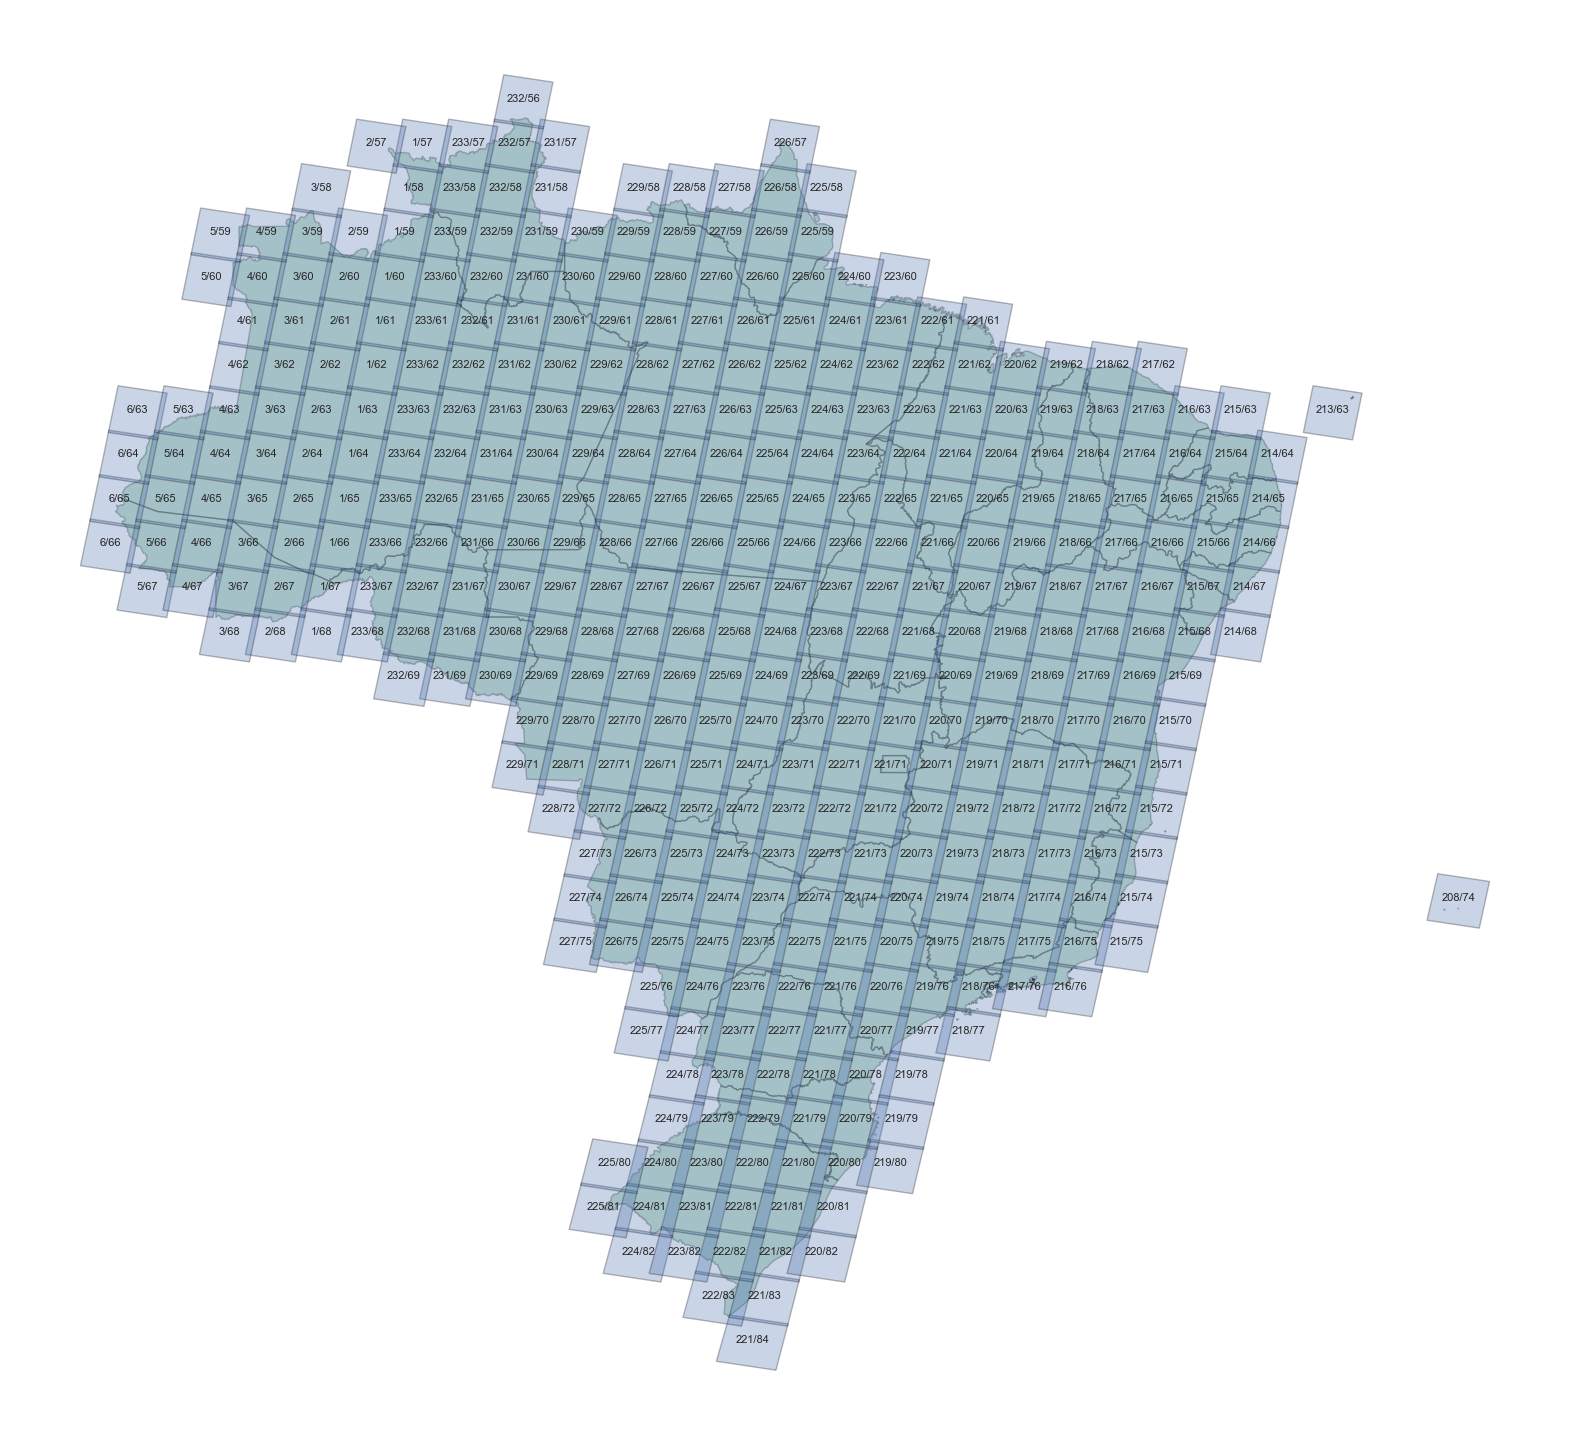

In [112]:
wrs2: gpd.GeoDataFrame = gpd.read_file('tiff/WRS2_descending_0')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 20))

join = gpd.sjoin(estados_shape, wrs2)
estados_shape.plot(
    ax=ax,
    edgecolor="k",
    facecolor='g',
    linewidth=1,
    alpha=0.3
)

wrs2.iloc[join['index_right'].unique()].plot(
    ax=ax,
    edgecolor="k",
    linewidth=1,
    alpha=0.3
)
wrs2.iloc[join['index_right'].unique()].apply(
    lambda x: ax.annotate(text=f'''{x['PATH']}/{x['ROW']}''', xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), 
    axis=1
)
ax.set_axis_off()
# cx.add_basemap(ax, crs=estados_shape.crs.to_string())

In [ ]:
# analise do horários das medicoes dos satelites
def time_measure_dist(satelite='AQUA_M-T', ax: plt.Axes=plt.axes()):
  filtered_df = df[(df["simp_satelite"] == satelite)]
  time_counts = filtered_df.groupby([filtered_df['datahora'].dt.time])['datahora'].count()
  time_counts.index = pd.TimedeltaIndex(data=time_counts.index.astype('str'))
  
  if '00:00:00' not in time_counts.index:
    time_counts['00:00:00'] = 0
  if '23:59:59' not in time_counts.index:
    time_counts['23:59:59'] = 0
  time_counts = time_counts.resample('30min').sum().reindex().rename(satelite)
  time_counts.plot(ax=ax, c=satellites_colors[satelite], legend=True)

time_satellites = ['Suomi NPP', 'AQUA', 'NOAA-20', 'TERRA', 'GOES-16']
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for satelite in time_satellites:
  time_measure_dist(satelite, ax)

ax.set_title("Medidas no tempo dos satélites")
ax.set_ylabel('Detecções')
ax.set_xlabel('Horário')

In [ ]:
fig, axs=plt.subplots(1, 2, figsize=(15, 8))
day = "2022-08-10"
names = {
    "Suomi NPP": ["{} {}".format(day, "03:44"), "{} {}".format(day, "02:02"), "{} {}".format(day, "00:20")],
    "NOAA-20": ["{} {}".format(day, "02:53"), "{} {}".format(day, "01:05")],
    "AQUA": ["{} {}".format(day, "03:28"), "{} {}".format(day, "01:42")],
    "TERRA": ["{} {}".format(day, "11:45"), "{} {}".format(day, "10:02")],
}

names2 = {
    "Suomi NPP": ["{} {}".format(day, "14:36"), "{} {}".format(day, "16:17"), "{} {}".format(day, "12:58")],
    "NOAA-20": ["{} {}".format(day, "15:26"), "{} {}".format(day, "13:37")],
    "AQUA": ["{} {}".format(day, "13:57"), "{} {}".format(day, "15:44")],
    "TERRA": ["{} {}".format(day, "01:03"), "{} {}".format(day, "22:15")],
}

for (key, value) in names.items():
    for time in value:
        draw_orbit(
            range=pd.date_range(time, freq=timedelta(minutes=1), periods=300, tz=data_timezone),
            satelite=key,
            title="Primeira metade do dia {}".format(day),
            color=satellites_colors[key],
            ax=axs[0]
        )

for (key, value) in names2.items():
    for time in value:
        draw_orbit(
            range=pd.date_range(time, freq=timedelta(minutes=1), periods=300, tz=data_timezone),
            satelite=key,
            title="Segunda metade do dia {}".format(day),
            color=satellites_colors[key],
            ax=axs[1]
        )

# draw geostationary
axs[0].plot(-75.190, 0.0, 'o', color=satellites_colors['GOES-16'], label='GOES-16')
axs[1].plot(-75.190, 0.0, 'o', color=satellites_colors['GOES-16'], label='GOES-16')

handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].legend(by_label.values(), by_label.keys(), loc="lower left")

handles, labels = axs[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[1].legend(by_label.values(), by_label.keys(), loc="lower left")

contextily.add_basemap(
    axs[0], 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    axs[1], 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Voyager,
)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from sklearn.cluster import DBSCAN

def show_grid_in_brasil(grid: xarray.DataArray, ax: plt.Axes = None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    scale="10m"

    country_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale=scale,
        facecolor="none",
    )

    geographic_feature = cfeature.NaturalEarthFeature(
        category="physical",
        name="land",
        scale=scale,
        edgecolor='face',
        facecolor=cfeature.COLORS['land']
    )

    state_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale=scale,
        facecolor="none",
    )

    #  rect = patches.Rectangle((max_lat, max_lon), max_lon-min_lon, max_lat-min_lat, linewidth=1, edgecolor='r', facecolor='none')
    grid.plot(ax=ax, transform=ccrs.PlateCarree(), zorder=5)
    ax.set_xlim([-70, -35])
    ax.set_ylim([-30, 5])
    ax.add_feature(country_border, edgecolor="black", lw=2, zorder=4)
    ax.add_feature(state_border, edgecolor="black", lw=0.1, zorder=4)
    ax.add_feature(geographic_feature, zorder=3)
    ax.coastlines()
    ax.gridlines(draw_labels=True, zorder=6)

def show_clusters(data: pd.DataFrame, ax: plt.Axes = None, eps: float=0.10):
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    if data.empty:
        return
    min_samples = int(len(data.index) * 0.05)
    clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = clusterer.labels_
    unique_labels = set(labels)

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[clusterer.core_sample_indices_] = True

    colors = [plt.cm.gist_rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        ax.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5, label=k)

        xy = data[class_member_mask & ~core_samples_mask]
        ax.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=3)

    legend = ax.get_legend_handles_labels()
    if legend[1][-1] == '-1':
        legend[1][-1] = 'Ruído'
    ax.add_artist(ax.legend(*legend, loc="lower left", title="Clusters"))

def show_grid(grid: xarray.DataArray, ax: plt.Axes = None): 
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = plt.cm.get_cmap('Reds')
    grid.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    # ax.set_xlim([float(grid.coords['longitude'][0]), float(grid.coords['longitude'][-1])])
    # ax.set_ylim([float(grid.coords['latitude'][0]), float(grid.coords['latitude'][-1])])
    # ax.gridlines(draw_labels=True)

def show_time_grid(data: pd.DataFrame, data_range: pd.DatetimeIndex, 
                   min_lat: float, max_lat: float, min_lon: float, max_lon: float, 
                   columns=2, width=20, clusters: bool = True):
    data_space = sub_space(data, min_lat, max_lat, min_lon, max_lon)
    data_split = split_by_range(data_space, data_range)
    size = len(data_split) + 1
    rows = math.ceil(size/columns)
    print('Ploting with', size, 'Linhas', rows, '...')
    fig, axs = plt.subplots(rows, columns, figsize=(width, int((width-2)/columns) * rows), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    show_grid_in_brasil(
        xarray.DataArray([[0, 0], [0, 0]], dims=["latitude", "longitude"], coords={"longitude": [min_lon, max_lon], "latitude": [min_lat, max_lat]}), 
        axs.flat[0]
    )
    axs.flat[0].set_title("Brasil")
    for index, ax in enumerate(axs.flat[1:]):
        if index < len(data_split):
            if clusters:
                data_temp = data_split[index].rename(columns={'latitude' : 'y', 'longitude' : 'x'})[['y', 'x']]
                show_clusters(data_temp, ax)
            else:
                grid = compute_grid(data_split[index], min_lat, max_lat, min_lon, max_lon)
                show_grid(grid, ax)
            ax.set_title("{} até {}".format(data_range[index], data_range[index+1]))
            ax.set_xlim([min_lon, max_lon])
            ax.set_ylim([min_lat, max_lat])
            ax.gridlines(draw_labels=True)

    fig.tight_layout(h_pad=0.5, w_pad=0.5)

def show_satelites(data: pd.DataFrame, ax: plt.Axes):
    satelites_data = data['simp_satelite'].value_counts().where(lambda x : x != 0).dropna()
    for (i, satelite) in enumerate(satelites_data.index.tolist()):
        current = data[data['simp_satelite'] == satelite]
        gpd.GeoDataFrame(
            current,
            geometry=gpd.points_from_xy(current.longitude, current.latitude),
            crs="EPSG:4326"
        ).plot(
            ax=ax,
            color=satellites_colors[satelite],
            markersize=5,
            label="{} - {}".format(satelite, int(satelites_data[satelite]))
        )
    contextily.add_basemap(
        ax, 
        crs="EPSG:4326",
        source=contextily.providers.CartoDB.PositronNoLabels,
    )
    ax.legend(markerscale=3)

In [ ]:
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import Gridliner
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def explore_satelite_data(data: pd.DataFrame, title: str=''):
    min_lat = data['latitude'].min()
    max_lat = data['latitude'].max()
    min_lon = data['longitude'].min()
    max_lon = data['longitude'].max()
    eps = (max_lat - min_lat) / 8

    fig, axs = plt.subplots(2, 2, figsize=(14, 12), layout=None, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title, fontsize=16)

    axs.flat[0].set_title('Clusters dos focos')
    show_clusters(data.rename(columns={'latitude' : 'y', 'longitude' : 'x'})[['y', 'x']], axs.flat[0], eps=eps)
    
    axs.flat[1].set_title('Áreas cobertas em cada foco')
    show_satelites_areas(data_temp, axs.flat[1])

    axs.flat[2].set_title('Agrupamento simples')
    grid = compute_grid(data)
    show_grid(grid, axs.flat[2])

    fig.tight_layout(pad=0.0)
    for ax in axs.flat:
        ax.set_xlim([min_lon, max_lon])
        ax.set_ylim([min_lat, max_lat])
        ax.label_outer()
        gl: Gridliner = ax.gridlines(draw_labels=True)
        gl.xlocator = mtick.MaxNLocator(5)
        gl.ylocator = mtick.MaxNLocator(6)
        gl.n_steps = 9
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlines = grid.sizes['longitude']
        gl.ylines = grid.sizes['latitude']
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

data_temp = sub_space(df.query("'2022-09-02 12:00:00-03:00' < datahora < '2022-09-02 16:00:00-03:00'"), -9.05, -8.95, -51, -50.9)
explore_satelite_data(data_temp, 'Resumo entre 2022-09-02 12:00:00 e 2022-09-02 16:00:00')

In [ ]:
show_time_grid(df, pd.date_range("2010-08-10", freq="1D", periods=25, tz=data_timezone), -9.5, -8.5, -51, -50, clusters=True)

In [ ]:
show_time_grid(df, pd.date_range("2022-09-02", freq="4H", periods=25, tz=data_timezone), -9.05, -8.94, -51, -50.9, clusters=False)

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(20, 30))
year = 2021
for i, ax in enumerate(axs.flat):
  month = i+1
  temp_df = reference_df.query('mes == {} and ano == {}'.format(month, year))
  ax.set_xlim([-80, -30])
  ax.set_ylim([-35, 10])
  sns.kdeplot(
      x=temp_df.longitude,
      y=temp_df.latitude,
      n_levels=50,
      fill=True,
      alpha=0.40,
      cmap="hot",
      bw_adjust=0.6,
      #cbar=True,
      ax=ax
  )
  ax.set_title("KDE do mês {} de {}".format(months_list[i], year))
  contextily.add_basemap(
      ax, 
      crs="EPSG:4326",
      source=contextily.providers.CartoDB.PositronNoLabels,
  )